# Hyperparameter Optimization using Optuna

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/fundamentals/optuna.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

```text
𝗔𝘂𝘁𝗵𝗼𝗿: Ron Medina
𝗟𝗮𝘀𝘁 𝗠𝗼𝗱𝗶𝗳𝗶𝗲𝗱: 2022/06/27
𝗗𝗲𝘀𝗰𝗿𝗶𝗽𝘁𝗶𝗼𝗻: Exploring the basics of Optuna for hyperparameter tuning.
```

---

## Introduction

Hyperparameters are non-learnable parameters of a model that determine its architecture or configuration. Properly tuning the hyperparameters of a model could mean the difference between converging or divergence from a solution, e.g. choosing the proper learning rate size in a model that trains with gradient descent. In this notebook, we will explore **Optuna**: a framework agnostic package for hyperparameter optimization.

Optuna uses black-box optimizers so we only need to provide a real-valued objective function which returns an evaluation of the hyperparameters and it works with any machine learning or deep learning package. Here we will use it to train scikit-learn and PyTorch models. Our main task then as developers would be to write a suitable objective function, set a reasonable budget, carefully define a search space, and finally interpret results. These correspond to manipulating the `study` and the `trial` objects as we will show in the following section.

In [2]:
import optuna
print(optuna.__version__)

2.10.0


## Basics with scikit-learn

The example below should serve as an archetype use-case of Optuna. 
Note that code for defining the search space via the `trial` object can be highly modular: 
the user can dynamically construct the search spaces for the hyperparameters within imperative Python code such as conditionals or loops, as well as define functions for handling `trial` objects. 

In [3]:
from sklearn import ensemble, svm
from sklearn import datasets
from sklearn import model_selection
from functools import partial

import warnings
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.simplefilter(action='ignore', category=FutureWarning) 


# [1] Define an objective function to be maximized.
def objective(trial, X, y):
    
    # [2] Suggest values for the hyperparameters using trial object.
    clf_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if clf_name == 'SVC':
        svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        clf = svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        clf = ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    # Always cross-validate!
    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()

# [3] Create a study object and optimize the objective function.
X, y = datasets.load_breast_cancer(return_X_y=True)
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, X=X, y=y), n_trials=5, n_jobs=-1)

[I 2022-04-20 15:24:57,832] A new study created in memory with name: no-name-f9237140-efe4-4220-948f-a0fca018dbbd
[I 2022-04-20 15:25:00,013] Trial 2 finished with value: 0.9543238627542309 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 6}. Best is trial 2 with value: 0.9543238627542309.
[I 2022-04-20 15:25:00,073] Trial 1 finished with value: 0.9420431609998448 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 14}. Best is trial 2 with value: 0.9543238627542309.
[I 2022-04-20 15:25:00,095] Trial 3 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 631.8099661998731}. Best is trial 2 with value: 0.9543238627542309.
[I 2022-04-20 15:25:00,107] Trial 4 finished with value: 0.947290793355069 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 7}. Best is trial 2 with value: 0.9543238627542309.
[I 2022-04-20 15:25:00,129] Trial 0 finished with value: 0.95960254618848 and parameters: {'classifier': 'RandomForest', '

The result of each trial can be accessed in the study object:

In [4]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_rf_max_depth,params_svc_c,state
0,0,0.959603,2022-04-20 15:24:57.834571,2022-04-20 15:25:00.129275,0 days 00:00:02.294704,RandomForest,12.0,NaN,COMPLETE
1,1,0.942043,2022-04-20 15:24:57.836540,2022-04-20 15:25:00.073071,0 days 00:00:02.236531,RandomForest,14.0,NaN,COMPLETE
2,2,0.954324,2022-04-20 15:24:57.839573,2022-04-20 15:25:00.013076,0 days 00:00:02.173503,RandomForest,6.0,NaN,COMPLETE
3,3,0.627418,2022-04-20 15:24:57.840926,2022-04-20 15:25:00.095832,0 days 00:00:02.254906,SVC,NaN,631.809966,COMPLETE
4,4,0.947291,2022-04-20 15:24:57.841747,2022-04-20 15:25:00.107127,0 days 00:00:02.265380,RandomForest,7.0,NaN,COMPLETE


### Fine tuning Random Forest

Here we focus on tuning a single Random Forest model. Then, plot the accuracy for each pair of hyperparameters.

In [5]:
def objective(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 128, log=True)    
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 800, log=True)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    clf = ensemble.RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=max_features,
        criterion=criterion,
        random_state=42)   
    
    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60, n_jobs=-1)

[I 2022-04-20 15:25:02,696] A new study created in memory with name: no-name-29b30d47-a1e6-46ba-9ef6-315e9272ac1e
[I 2022-04-20 15:25:03,152] Trial 0 finished with value: 0.9490607048594939 and parameters: {'max_depth': 2, 'max_features': 0.21018233732488012, 'n_estimators': 369, 'criterion': 'gini'}. Best is trial 0 with value: 0.9490607048594939.
[I 2022-04-20 15:25:03,243] Trial 3 finished with value: 0.9508150908244062 and parameters: {'max_depth': 2, 'max_features': 0.7106044354537339, 'n_estimators': 114, 'criterion': 'entropy'}. Best is trial 3 with value: 0.9508150908244062.
[I 2022-04-20 15:25:03,675] Trial 1 finished with value: 0.9543393882937432 and parameters: {'max_depth': 18, 'max_features': 0.8049366305880424, 'n_estimators': 155, 'criterion': 'gini'}. Best is trial 1 with value: 0.9543393882937432.
[I 2022-04-20 15:25:04,323] Trial 2 finished with value: 0.9578481602235678 and parameters: {'max_depth': 21, 'max_features': 0.18005304030929517, 'n_estimators': 203, 'crit

In [6]:
study.best_params

{'max_depth': 17,
 'max_features': 0.4781776410846381,
 'n_estimators': 328,
 'criterion': 'entropy'}

In [7]:
study.best_value

0.9701443875174661

### Sampling algorithms

Optuna uses  **Tree-structured Parzen Estimater** (**TPE**) {cite}`bergstra` as the default sampler which is a form of Bayesian optimization. Observe that the hyperparameter space is searched more efficiently than random search with the sampler choosing points closer to previous good results. Samplers are specified when creating a study: 

```python
study = create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
```

TPE samples every hyperparameter independently. From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler):

> On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) `l(x)` to the set of parameter values associated with the best objective values, and another GMM `g(x)` to the remaining parameter values. It chooses the parameter value `x` that maximizes the ratio `l(x)/g(x)`.

The following plot shows the difference between TPE with grid and random sampling:

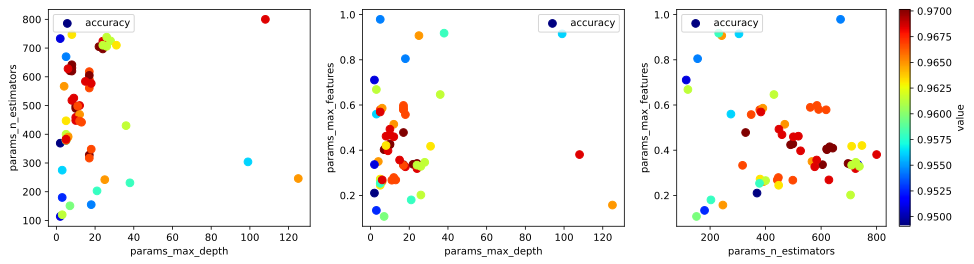

In [8]:
def plot_results(study, ax, p1, p2, j, cb):
    study.trials_dataframe().plot(
        kind='scatter', ax=ax[j], x=p1, y=p2,
        c='value', s=60, cmap=plt.get_cmap("jet"), 
        colorbar=cb, label="accuracy", figsize=(16, 4)
    )

fig, ax = plt.subplots(nrows=1, ncols=3)
plot_results(study, ax, 'params_max_depth',    'params_n_estimators', j=0, cb=False)
plot_results(study, ax, 'params_max_depth',    'params_max_features', j=1, cb=False)
plot_results(study, ax, 'params_n_estimators', 'params_max_features', j=2, cb=True);

$ $

```{figure} ../../img/optuna-samplers.png
---
name: optuna-samplers
---
List of all [sampling algorithms](https://optuna.readthedocs.io/en/stable/reference/samplers.html) as of version 2.10.0.
```

Another sampling algorithm implemented is **Covariance Matrix Adaptation Evolution Strategy** (**CMA-ES**) {cite}`hansen2016cma`. This algorithm is designed to tackle ill-conditioned, non-separable problems, i.e. cannot be solved by solving several 1-dimensional problems. CMA-ES is typically implemented along with TPE whenever the former algorithm is not applicable, e.g. for searching dynamically constructed hyperparameters (as CMA-ES requires that parameters are specified statically prior to the optimization) or for searching categorical parameters, as CMA-ES is designed to search real parameters on a continuous domain. TPE + CMA-ES sampling can be implemented as follows:

```python
sampler = optuna.samplers.CmaEsSampler(
    warn_independent_sampling=False,
    independent_sampler=optuna.samplers.TPESampler()
)
```

Results from the paper {cite}`akiba2019optuna` show that TPE + CMA-ES works better than counterparts of the same time complexity:

```{figure} ../../img/fig9-optuna.png
---
width: 35em
name: fig9-optuna
---
Result of comparing TPE+CMA-ES against other existing methods in terms of best attained objective value. (Figure 9 in {cite}`akiba2019optuna`)
```

```{figure} ../../img/fig10-optuna.png
---
width: 35em
name: fig10-optuna
---
Computation time spent by different frameworks for each test case. (Figure 10 in {cite}`akiba2019optuna`)
```

## Results visualization

**History.** Optuna provides visualization functions in the `optuna.visualization` library. The following plot shows the best objective value found as the trials progress. The increasing trend in accuracy indicates that the TPE sampler is working well, i.e. the search algorithm learns from previous trials.

```{margin}
The plots are displayed in SVG format due to technical difficulties. Running them locally with the default renderer results in [interactive plotly plots](https://plotly.com/python/getting-started/).
```

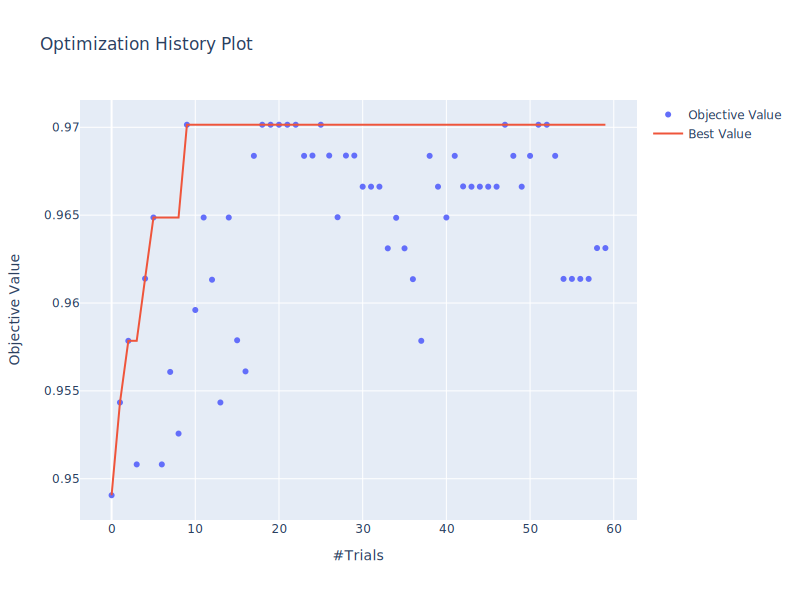

In [9]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show(renderer="svg")

**Parallel coordinate plot.** The parallel coordinate plot gives us a feel of how the hyperparameters interact. To isolate subsets of lines, we can use the interactive capabilities of the plots by dragging on each axis to restrict it. The resulting purple bars can be disjoint.

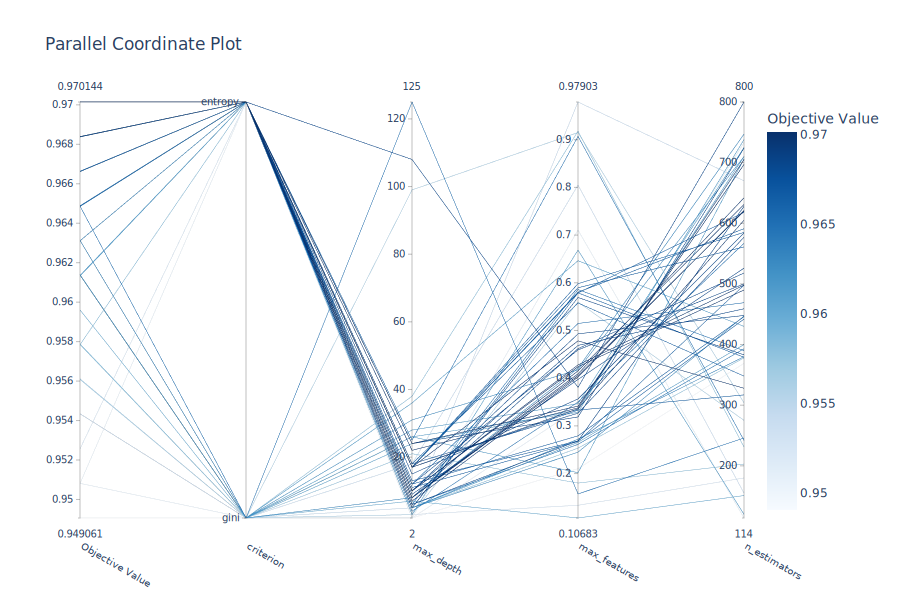

In [10]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=900, height=600)
fig.show(renderer="svg")

**Slice plots.** Slice plots show the projections of the sampler's path in the hyperparameter space in each individual dimension, then shifts each point along the vertical axis based on the its objective value. 

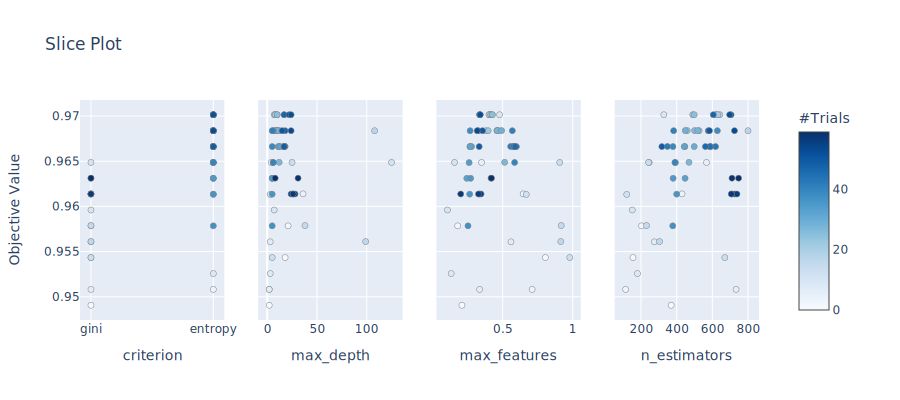

In [11]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(width=900, height=400)
fig.show(renderer="svg")

**Hyperparameter importance.** The default importance evaluator is `FanovaImportanceEvaluator`. This takes as input performance data gathered with different hyperparameter settings of the algorithm, fits a random forest to capture the relationship between hyperparameters and performance, and then applies functional ANOVA to assess how important each of the hyperparameters and each low-order interaction of hyperparameters is to performance {cite}`pmlr-v32-hutter14`. From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html):

> The performance of fANOVA depends on the prediction performance of the underlying random forest model. In order to obtain high prediction performance, it is necessary to cover a wide range of the hyperparameter search space. It is recommended to use an exploration-oriented sampler such as `RandomSampler`.

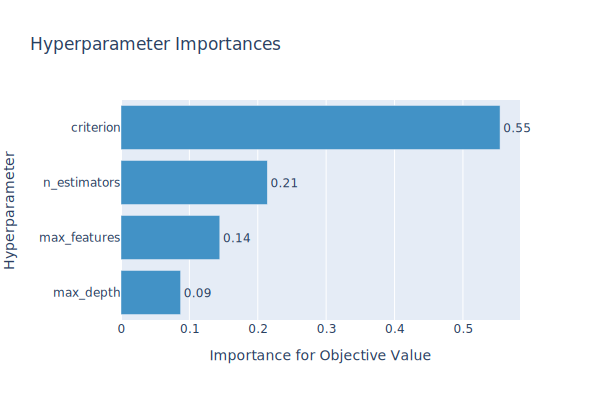

In [12]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=600, height=400)
fig.show(renderer="svg")

**Contour plots.** To visualize interactions between any pair of hyperparameters spatially, we can generate contour plots where regions of *low* objective value are darker in color.

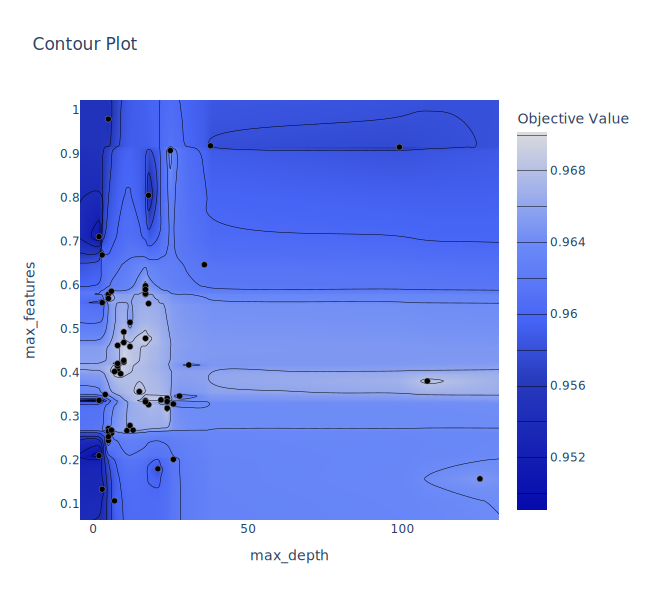

In [13]:
fig = optuna.visualization.plot_contour(study, params=["max_depth", "max_features"])
fig.update_layout(width=650, height=600)
fig.show(renderer="svg")

## Neural networks

As noted above, we should always perform tuning within a cross-validation framework. However, with neural networks, performing 5-fold cross validation would require too much compute time and resources. Instead, we minimize the loss on a hold-out validation set. Note that Optuna provides multi-objective optimization, for example, [minimizing FLOPS while maximizing accuracy](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html). Multi-objective optimization uses the [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) to determine optimal solutions.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils import data

from tqdm.notebook import tqdm
import optuna
import numpy as np

PATIENCE = 5
EPOCHS = 100
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
VGG_NTRIALS = 40
CIFAR10_SAMPLE_RATIO = 0.5
CIFAR10_RESIZE = 32

Define a convolutional network with a smaller version of the VGG architecture.

In [19]:
def vgg_block(num_convs, in_channels, out_channels):
    """
    Convolutional block of a VGG network. Source: 
    https://d2l.ai/chapter_convolutional-modern/vgg.html
    """
    
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size=3, padding=1
            )
        )
        layers.append(nn.ReLU())
        in_channels = out_channels
    
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)


def vgg(conv_arch, linear_width, dropout, in_channels=3):
    """Network with VGG architecture."""

    conv_blocks = []
    for (num_convs, out_channels) in conv_arch:
        conv_blocks.append(
            vgg_block(
                num_convs, 
                in_channels, 
                out_channels
            )
        )
        in_channels = out_channels

    height, width = 6, 6
    dense_layers = [
        nn.AdaptiveAvgPool2d((height, width)),
        nn.Flatten(),
        nn.Linear(out_channels * height * width, linear_width),
        nn.ReLU(), 
        nn.Dropout(dropout),
        nn.Linear(linear_width, linear_width),
        nn.ReLU(), 
        nn.Dropout(dropout),
        nn.Linear(linear_width, 10)
    ]
    return nn.Sequential(*(conv_blocks + dense_layers))

We also define a `Dataset` class for CIFAR-10.

In [20]:
# Download and preprocess CIFAR-10 dataset
transform = []
if CIFAR10_RESIZE:
    transform.append(transforms.Resize(CIFAR10_RESIZE))

transform.append(transforms.ToTensor())
transform = transforms.Compose(transform)

cifar_train = datasets.CIFAR10(root=".", train=True,  transform=transform, download=True)
cifar_valid = datasets.CIFAR10(root=".", train=False, transform=transform, download=True)


def get_cifar10_dataloaders(batch_size, sample_ratio=1.0):
    """Utility function for getting train and valid dataloaders."""
    
    train_loader = data.DataLoader(
        cifar_train, 
        batch_size, 
        drop_last=True, 
        sampler=range(int(len(cifar_train)*sample_ratio))
    )
    
    valid_loader = data.DataLoader(
        cifar_valid, 
        batch_size, 
        drop_last=True, 
        sampler=range(int(len(cifar_valid)*sample_ratio))
    )
    
    return train_loader, valid_loader

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Define a trainer for the neural network model. This will handle all loss and metric evaluation, as well as backpropagation.

In [21]:
class Engine:
    """Facilitate neural network training and evaluation."""
    
    def __init__(self, model, device, optimizer):
        self.model = model
        self.device = device
        self.optimizer = optimizer 

    @staticmethod
    def loss_fn(outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)
        
    def train(self, data_loader):
        """Train model on one epoch. Return train loss."""
        
        self.model.train()
        loss = 0
        for i, (data, targets) in enumerate(data_loader):
            data = data.to(self.device).float()
            targets = targets.to(self.device).long()
            
            # Forward pass
            outputs = self.model(data)
            J = self.loss_fn(outputs, targets)
            
            # Backward pass
            self.optimizer.zero_grad()
            J.backward()
            self.optimizer.step()

            # Cumulative loss
            loss += (J.detach().item() - loss) / (i + 1)

        return loss


    def eval(self, data_loader):
        """Return validation loss and validation accuracy."""
        
        self.model.eval()
        num_correct = 0
        num_samples = 0
        loss = 0.0
        with torch.no_grad():
            for i, (data, targets) in enumerate(data_loader):
                data = data.to(self.device).float()
                targets = targets.to(self.device)
                
                # Forward pass
                out = self.model(data)
                J = self.loss_fn(out, targets)
                _, preds = out.max(dim=1)

                # Cumulative metrics
                loss += (J.detach().item() - loss) / (i + 1)
                num_correct += (preds == targets).sum().item()
                num_samples += preds.shape[0]

        acc = num_correct / num_samples
        return loss, acc

### Pruning trials based on intermediate values

Finally, we set up the `study` instance and its objective function. Note that the search space is dynamically constructed depending on the number of layers (i.e. an earlier suggestion for a hyperparameter). During training, we perform early stopping on validation loss. If no new minimum validation loss is found after 5 epochs, then the minimum validation loss is returned as the objective.

Computing intermediate values allow us to **prune** unpromising trials to conserve resources. We use the default pruner [`MedianPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html) which prunes a trial if its best intermediate result as of the current step (e.g. current best valid loss) is worse than the median of all intermediate results of previous trials *at the current step*. Hence, the best intermediate result of a pruned trial is less than the best intermediate result of 1/2 of the other trials as of that step. In our case, if the minimum validation loss does not improve too quickly, then the trial is pruned. Of course, the validation loss could descend rapidly at later steps, but the median pruner does not bet on this happening.

In [24]:
def run_training(trial, train_loader, valid_loader, engine):
    """Run training with early stopping. Return best validation loss."""

    best_loss = np.inf
    patience = PATIENCE
    loop = tqdm(range(EPOCHS), total=EPOCHS, leave=False)
    for epoch in loop:

        # Train and validation step
        train_loss = engine.train(train_loader)
        valid_loss, valid_acc = engine.eval(valid_loader)
            
        # Early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = PATIENCE
        else:
            patience -= 1
            if patience == 0:
                break
    
        # Pruning unpromising trials
        trial.report(valid_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(
            val_loss=valid_loss, 
            acc=valid_acc, 
            patience=patience,
            lr=engine.optimizer.param_groups[0]['lr'])
        
    return best_loss


def objective(trial):
    """Return best validation loss for given network architecture."""

    # Setup architecture
    conv_arch = [
        (1, trial.suggest_int(f"vgg_b1", 128, 512, log=True)),
        (2, trial.suggest_int(f"vgg_b2", 128, 512, log=True)),
        (2, trial.suggest_int(f"vgg_b3", 128, 512, log=True)),
    ]
    dense_width = trial.suggest_int("dense", 256, 1024, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 1.0, step=0.1)
    learning_rate = trial.suggest_float("lr", 1e-5, 0.3, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128, log=True)

    # Initialize engine
    model = vgg(conv_arch, dense_width, dropout).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)    
    engine = Engine(model, DEVICE, optimizer)
    
    # Initalize data loaders
    train_loader, valid_loader = get_cifar10_dataloaders(
        batch_size, sample_ratio=CIFAR10_SAMPLE_RATIO)
    
    # Start training run
    score = run_training(trial, train_loader, valid_loader, engine)
    return score

This study looks rather complicated, with a lot of moving parts. We can test the objective using a `FixedTrial` which suggests fixed parameter values based on a given dictionary of parameters:

```python
trial = FixedTrial(param_dict)
objective(trial) 
```

Running the minimization problem with `MedianPruner`. The parameters of the pruner will be explained below.

In [25]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=15, n_min_trials=5)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=VGG_NTRIALS, n_jobs=-1)

[I 2022-03-29 05:56:29,769] A new study created in memory with name: no-name-7a289cf4-0c0a-4863-85b9-9ad2a39a5da3
[I 2022-03-29 06:01:01,693] Trial 0 finished with value: 2.316252053607994 and parameters: {'vgg_b1': 364, 'vgg_b2': 232, 'vgg_b3': 226, 'dense': 294, 'dropout': 0.8, 'lr': 0.08796261436213096, 'batch_size': 23}. Best is trial 0 with value: 2.316252053607994.
[I 2022-03-29 06:02:59,187] Trial 1 finished with value: 1.013104486019433 and parameters: {'vgg_b1': 358, 'vgg_b2': 429, 'vgg_b3': 243, 'dense': 471, 'dropout': 0.1, 'lr': 0.00037818973842870097, 'batch_size': 34}. Best is trial 1 with value: 1.013104486019433.
[I 2022-03-29 06:05:37,313] Trial 3 finished with value: 2.3039556230817517 and parameters: {'vgg_b1': 504, 'vgg_b2': 275, 'vgg_b3': 174, 'dense': 273, 'dropout': 0.8, 'lr': 0.018555785345731025, 'batch_size': 89}. Best is trial 1 with value: 1.013104486019433.
[I 2022-03-29 06:10:45,462] Trial 2 finished with value: 0.9313148994897976 and parameters: {'vgg_b1'

In [75]:
from optuna.trial import TrialState

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials:\t", len(study.trials))
print("  Number of pruned trials:\t", len(pruned_trials))
print("  Number of complete trials:\t", len(complete_trials))

print("\nBest trial:")
best_trial = study.best_trial

print("  Number:", best_trial.number)
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:	 40
  Number of pruned trials:	 7
  Number of complete trials:	 33

Best trial:
  Number: 32
  Value:  0.8700614416080973
  Params: 
    vgg_b1: 306
    vgg_b2: 174
    vgg_b3: 352
    dense: 449
    dropout: 0.30000000000000004
    lr: 9.153843325718859e-05
    batch_size: 54


Comparing the best result with some hand-designed network that resembles the [VGG architecture](https://d2l.ai/chapter_convolutional-modern/vgg.html#vgg-network):

In [71]:
param_dict = {
    "vgg_b1": 64,
    "vgg_b2": 128,
    "vgg_b3": 256,
    "dense": 1024,
    "dropout": 0.5,
    "lr": 0.1,
    "batch_size": 32
}

trial = optuna.trial.FixedTrial(param_dict)
objective(trial) 

  0%|          | 0/100 [00:00<?, ?it/s]

2.3142308332981214

Trials either early stops (starts overfitting) or gets pruned (expected to not improve even if gradient descent continues). Pruning starts after 10 trials are completed, i.e. `n_startup_trials=10`. This is so that the pruner obtains enough information about the general behavior of the gradient descent optimizer before starting to prune. 

We set `n_warmup_steps=15` allowing each trial to train the network for 16 epochs before pruning, so that the completed trials will not be dominated by networks that descend quickly, but to shallow minimas. For example, shallow networks that possibly overfits the validation set. However, this comes at the price of wasting resources for training 16 epochs for around half of the number of trials. Finally, we set `n_min_trials=5` so that a higher number of trials at later steps can continue until it early stops or reaches max epochs.

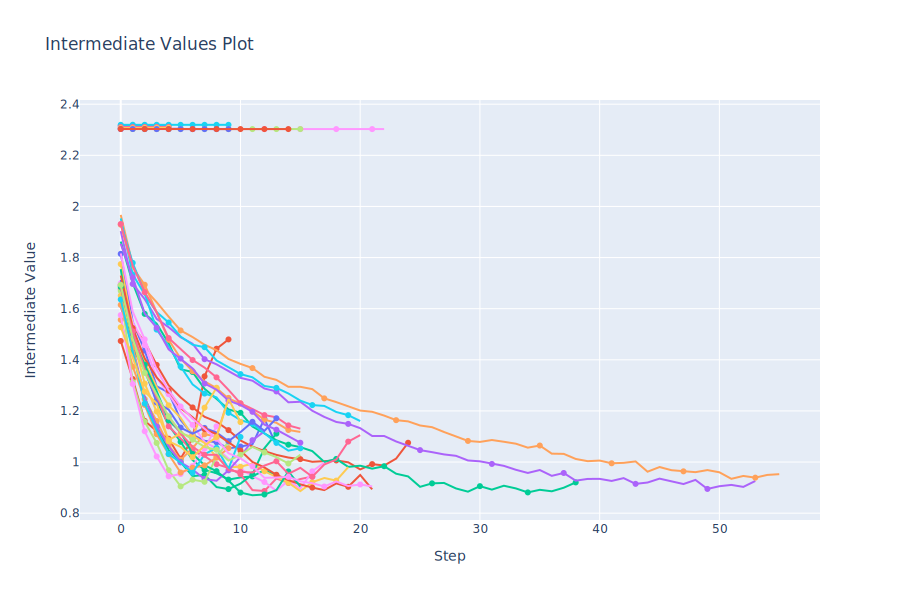

In [47]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.update_layout(width=900, height=600)
fig.show(renderer="svg")

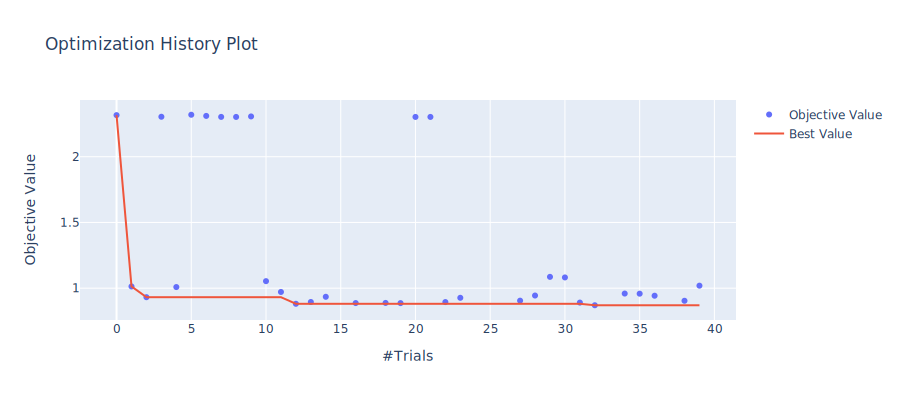

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=900, height=400)
fig.show(renderer="svg")

We can look at the distribution of best validation losses.

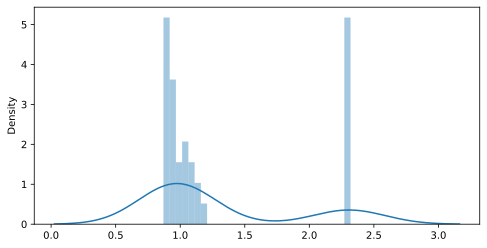

In [52]:
import seaborn as sns
plt.figure(figsize=(8, 4), dpi=80)
sns.distplot(study.trials_dataframe().value.values, bins=30);

### Hyperparameter interactions

The parallel coordinate plot below shows which combination of hyperparameters work. We can also use this to select low complexity models with similar performance to the best performance. 

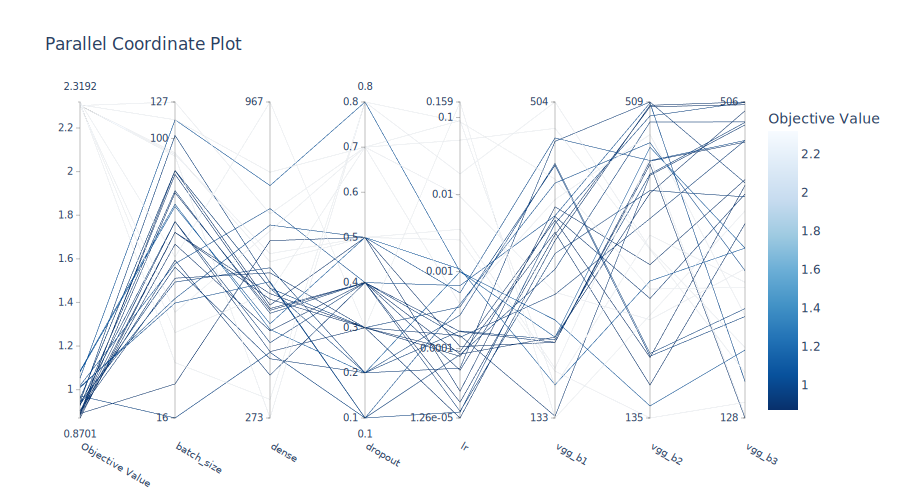

In [55]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=900, height=500)
fig.show(renderer="svg")

Slice plots can be used as guide to parameter ranges to search when making an updated study, i.e. re-running the experiment with tighter ranges. 

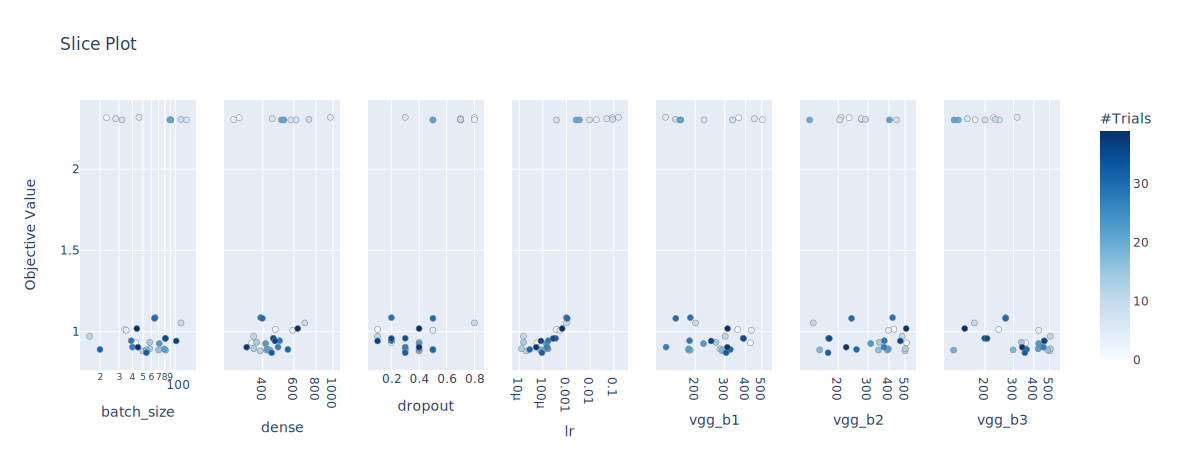

In [56]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(width=1200, height=450)
fig.show(renderer="svg")

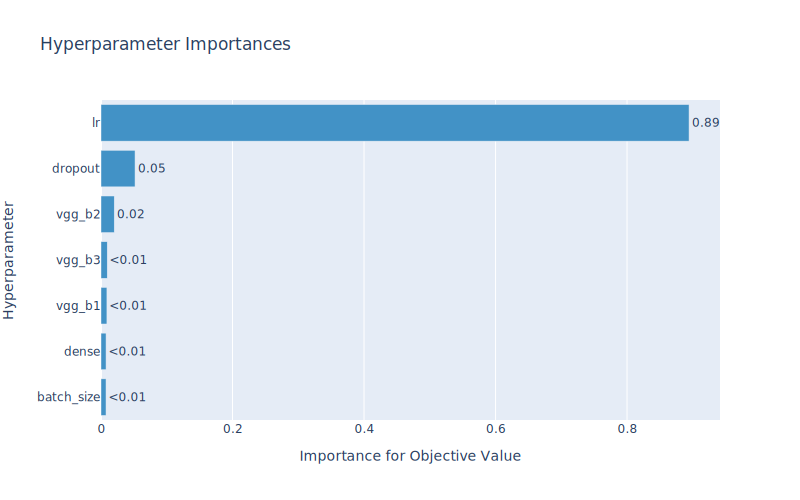

In [57]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=800, height=500)
fig.show(renderer="svg")

Let us look at how learning rate, batch size, and the size upper block of the network affects the loss value. 

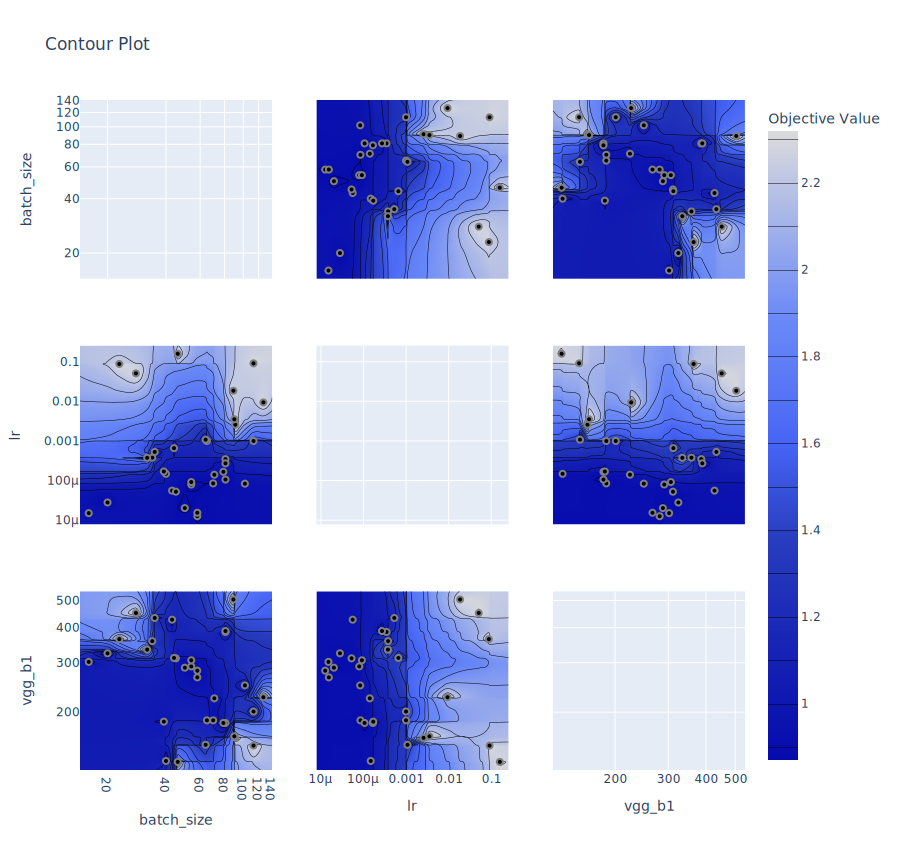

In [63]:
fig = optuna.visualization.plot_contour(study, params=['lr', 'batch_size', 'vgg_b1'])
fig.update_layout(autosize=False, width=900, height=850)
fig.show(renderer="svg")

Finally, we look at the contour plot for the hyperparameters on the bottom architecture. 

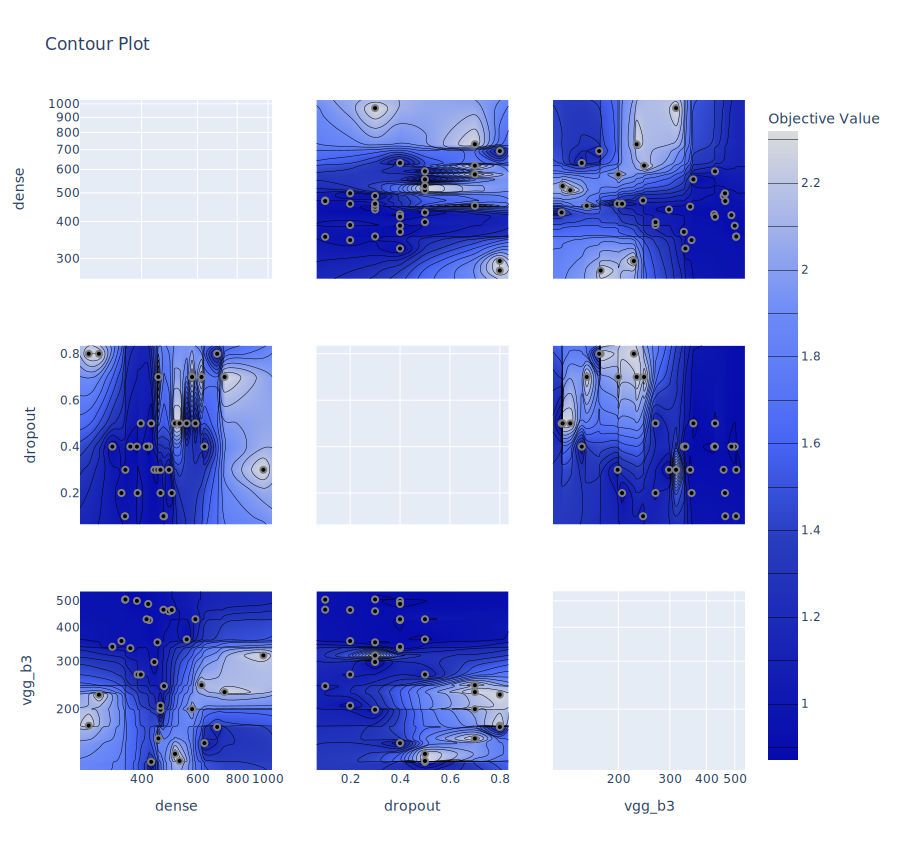

In [62]:
fig = optuna.visualization.plot_contour(study, params=['vgg_b3', 'dense', 'dropout'])
fig.update_layout(autosize=False, width=900, height=850)
fig.show(renderer='svg')

## Appendix: Hyperparameters of commonly used models

### Classical models + XGBoost

```{figure} ../../img/hyp.png
---
name: hyp
---
Table from p. 184 of {cite}`AAAMLP`. **RS**$^*$ implies random search should be better.
```

### XGBoost parameter space

Search space for tuning XGBoost in the [autoxgb](https://github.com/abhishekkrthakur/autoxgb) package:

```python
#https://github.com/abhishekkrthakur/autoxgb/blob/main/src/autoxgb/params.py
def get_params(trial, model_config):
    
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 100, 500),
        "n_estimators": trial.suggest_categorical("n_estimators", [7000, 15000, 20000]),
    }
    
    if model_config.use_gpu:
        params["tree_method"] = "gpu_hist"
        params["gpu_id"] = 0
        params["predictor"] = "gpu_predictor"
    else:
        params["tree_method"] = trial.suggest_categorical("tree_method", ["exact", "approx", "hist"])
        params["booster"] = trial.suggest_categorical("booster", ["gbtree", "gblinear"])
        if params["booster"] == "gbtree":
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    return params
```